In [241]:
import numpy as np
import torch
import pandas as pd
%matplotlib inline
%load_ext autoreload
%autoreload 2
from importlib import reload
import hdataset
import matplotlib.pyplot as plt
from collections import OrderedDict

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [159]:
df = pd.read_csv("/data/neurovault/resampled_dataframe.csv")


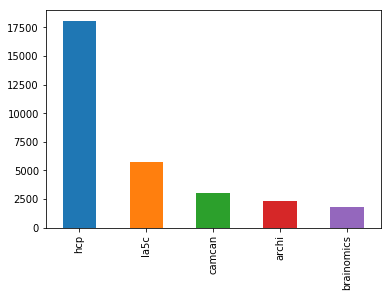

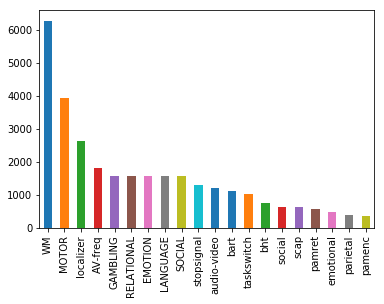

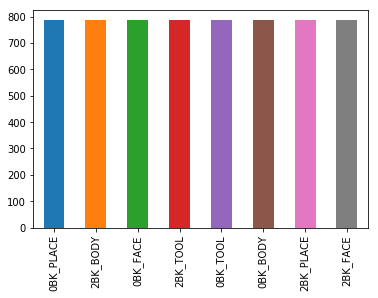

In [256]:
fig, ax = plt.subplots()
df['study'].value_counts().plot(ax=ax, kind='bar')
plt.show()

fig, ax = plt.subplots()
df['task'].value_counts().plot(ax=ax, kind='bar')
plt.show()

fig, ax = plt.subplots()
df.loc[df.task == 'WM'].contrast.value_counts().plot(ax=ax, kind='bar')
plt.show()

In [161]:
s2t = {}
s2c = {}
studies = ['archi', 'hcp', 'la5c', 'camcan', 'brainomics']
df = pd.read_csv("/data/neurovault/resampled_dataframe.csv")
stats = pd.read_csv("/data/neurovault/stats.csv")
stats.set_index(keys=['study'], drop=False, inplace=True)
stats_dict = stats.to_dict(orient='index')
# A dict of dataframes.
# For each study of df
# create a dataframe and return
# sort the dataframe
df.sort_values(by='study', axis=0, inplace=True)
# set the index to be this and don't drop
df.set_index(keys=['study'], drop=False, inplace=True)
# get a list of names
studies = df['study'].unique().tolist()
studies = [x for x in studies]
# now we can perform a lookup on a 'view' of the dataframe
study_dfs = {study: df.loc[df.study == study] for study in studies}

for study in studies:
    study_df = study_dfs[study]
    # Split the study_df into half by subject.
    study_df = study_df.sort_values(by='subject', axis=0, inplace=False)
    # set the index to be this and don't drop
    study_df = study_df.set_index(keys=['subject'], drop=False, inplace=False)
    subjects = study_df['subject'].unique().tolist()
    train_subjects = subjects[:len(subjects) // 2]
    test_subjects = subjects[len(subjects) // 2:]
    train_dfs = [study_df.loc[study_df.subject == subj] for subj in train_subjects]
    test_dfs = [study_df.loc[study_df.subject == subj] for subj in test_subjects]

    contrasts_arr = study_df['contrast'].unique().tolist()
    # contrasts_dict = {contrast: i for i, contrast in enumerate(contrasts_arr)}

    # print("For {} we have contrasts:{}".format(study, contrasts_arr))

    tasks_arr = study_df['task'].unique().tolist()
    # tasks_dict = {task: i for i, task in enumerate(tasks_arr)}

    task_dict = {}
    task2contrasts_dict = {}
    contrasts_dict = {}
    for task in tasks_arr:
        contrast_list = study_df.loc[study_df.task == task].contrast.unique().tolist()
        task_dict[task] = len(task_dict)
        for contrast in contrast_list:
            if (contrast in contrasts_dict):
                continue
            contrasts_dict[contrast] = len(contrasts_dict)
        task2contrasts_dict[task] = [contrasts_dict[c] for c in contrast_list]
    s2t[study] = task_dict
    s2c[study] = contrasts_dict


In [162]:
s2c['camcan']

{'AudOnly': 0, 'AudVid1200': 2, 'AudVid300': 3, 'AudVid600': 4, 'VidOnly': 1}

In [163]:
import nilearn
import nilearn.image
import nibabel
import numpy as np
from torch.utils.data.dataset import Dataset
import scipy.ndimage
from nilearn.image import load_img, resample_img, crop_img, threshold_img, math_img
from nilearn.datasets import load_mni152_template, load_mni152_brain_mask
from nilearn import plotting
import nilearn.masking

In [164]:
full_template = template = load_mni152_template()
scaler = np.ones((4, 4), dtype=np.float)
target_shape = [30, 36, 30]
for i in range(3):
    scaler[i, i] = template.shape[i] / target_shape[i]
downsampled_affine = np.multiply(template.affine, scaler)


template = crop_img(template)
for i in range(3):
    scaler[i, i] = template.shape[i] / target_shape[i]
downsampled_affine = np.multiply(template.affine, scaler)

template = resample_img(template, target_shape=target_shape, target_affine=downsampled_affine)

/anaconda/envs/py35/lib/python3.5/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))


In [165]:
print(template.shape)

(30, 36, 30)


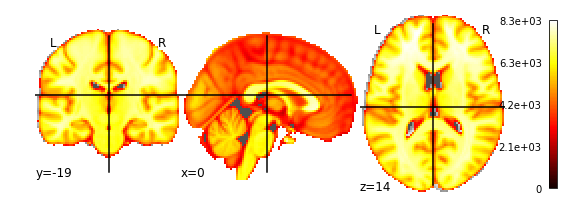

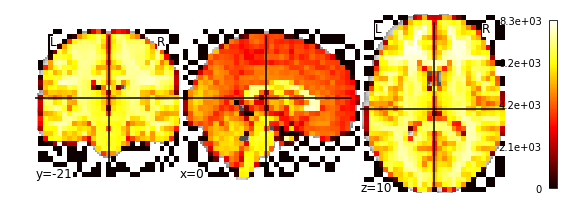

In [166]:
plotting.plot_stat_map(
    full_template,
    black_bg=False,
)
plotting.plot_stat_map(
    template,
    black_bg=False,
)
# plotting.plot_stat_map(
#     cropped_template,
#     black_bg=False,
# )


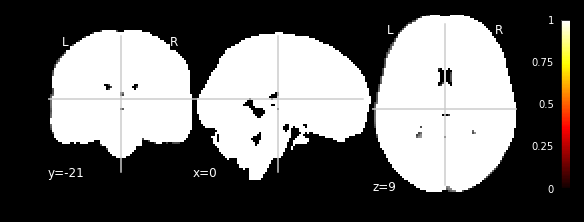

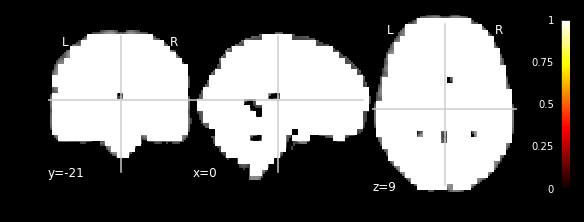

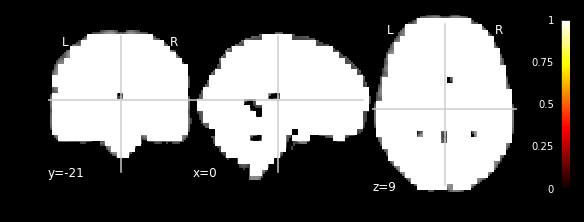

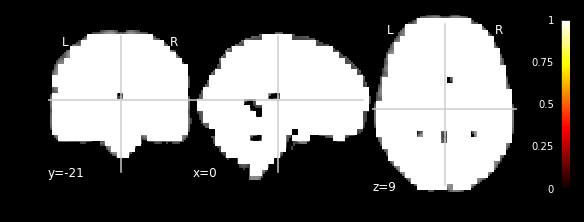

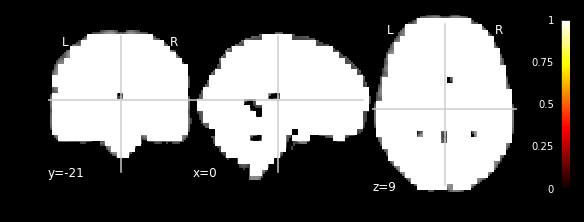

In [167]:
full_mask = load_mni152_brain_mask()
scaler = np.ones((4, 4), dtype=np.float32)
target_shape = [30, 36, 30]
for i in range(3):
    scaler[i, i] = full_mask.shape[i] / target_shape[i]
downsampled_affine = np.multiply(full_mask.affine, scaler)

downsampled_mask = resample_img(full_mask, target_shape=target_shape, target_affine=downsampled_affine, interpolation='nearest')
binarized_downsampled_mask = nibabel.Nifti1Image(downsampled_mask.get_data().astype(np.int), downsampled_mask.affine)
thr_downsampled_mask = threshold_img(downsampled_mask, 0.2)
binarized_thr_downsampled_mask_data = (thr_downsampled_mask.get_data() > 0).astype(np.int)
binarized_thr_downsampled_mask = nibabel.Nifti1Image(binarized_thr_downsampled_mask_data, thr_downsampled_mask.affine)
plotting.plot_stat_map(
    full_mask,
    black_bg=True,
)
plotting.plot_stat_map(
    downsampled_mask,
    black_bg=True,
)
plotting.plot_stat_map(
    binarized_downsampled_mask,
    black_bg=True,
)
plotting.plot_stat_map(
    thr_downsampled_mask,
    black_bg=True,
)
plotting.plot_stat_map(
    binarized_thr_downsampled_mask,
    black_bg=True,
)

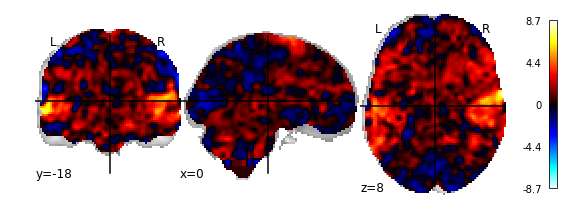

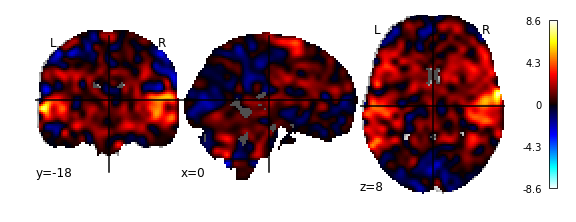

In [168]:
full_img = nibabel.load(df.iloc[0].z_map.replace("_down", ""))
full_img = crop_img(full_img)

small_img = nilearn.image.resample_to_img(full_img, downsampled_mask)
# img = nibabel.load(df.iloc[0].z_map)
# figure = plt.figure()
plotting.plot_stat_map(
    full_img,
    black_bg=False,
)
# plotting.plot_stat_map(
#     small_img,
#     black_bg=False,
# )
# plotting.plot_stat_map(
#     img,
#     black_bg=False,
# )
result_img = math_img("img1 * img2", img1=small_img, img2=downsampled_mask)
# plotting.plot_stat_map(
#     result_img,
#     black_bg=False,
# )
upsampled_img = nilearn.image.resample_to_img(result_img, full_template, interpolation='continuous')
fixed_upsampled_img = math_img("img1 * img2", img1=upsampled_img, img2=full_mask)
# plotting.plot_stat_map(
#     upsampled_img,
#     black_bg=False,
# )
plotting.plot_stat_map(
    fixed_upsampled_img,
    black_bg=False,
)

/data/neurovault/collection_4339/image_75358_down.nii.gz
(30, 36, 30)


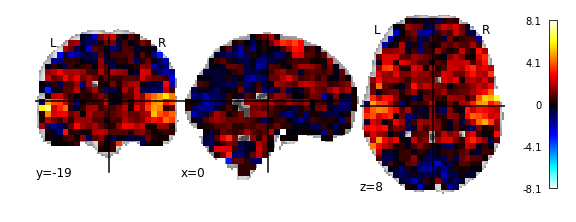

In [169]:
print(df.iloc[0].z_map)
full_img = nibabel.load(df.iloc[0].z_map)
plotting.plot_stat_map(
    full_img,
    black_bg=False,
)
print(full_img.get_data().shape)

/data/neurovault/collection_4339/image_75358.nii.gz
(91, 109, 91)


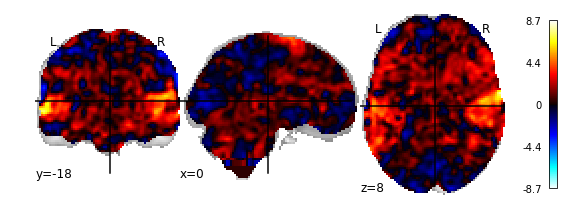

In [170]:
print(df.iloc[0].z_map.replace("_down", ""))
full_img = nibabel.load(df.iloc[0].z_map.replace("_down", ""))
plotting.plot_stat_map(
    full_img,
    black_bg=False,
)
print(full_img.get_data().shape)

/data/neurovault/collection_4337/image_80398.nii.gz
(91, 109, 91)


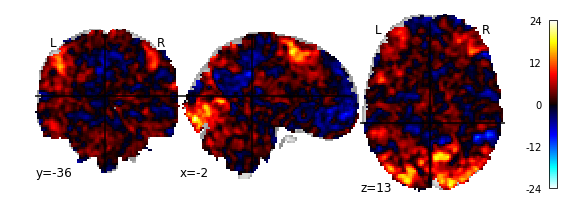

In [171]:
print(df.iloc[20000].z_map.replace("_down", ""))
full_img = nibabel.load(df.iloc[20000].z_map.replace("_down", ""))
plotting.plot_stat_map(
    full_img,
    black_bg=False,
)
print(full_img.get_data().shape)

In [172]:
stats_df = pd.read_pickle("/data/neurovault/stats.pkl")
downsampled_affine

array([[  -6.0666666 ,    0.        ,    0.        ,   90.        ],
       [   0.        ,    6.05555534,    0.        , -126.        ],
       [   0.        ,    0.        ,    6.0666666 ,  -72.        ],
       [   0.        ,    0.        ,    0.        ,    1.        ]])

In [183]:
stats_df.iloc[4]

study                                                brainomics
mu                                                      0.52995
sigma                                                   5.37913
n                                                          1786
mean_image    [[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...
std_image     [[[0.5299499559094337, 0.5299499559094337, 0.5...
Name: 4, dtype: object

0
1
2
3
4


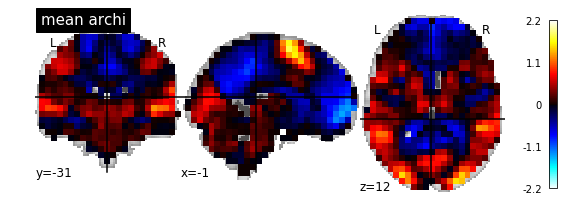

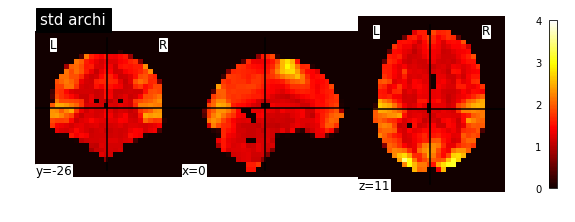

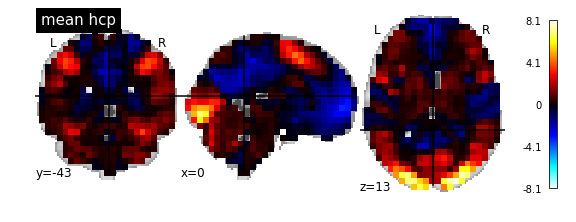

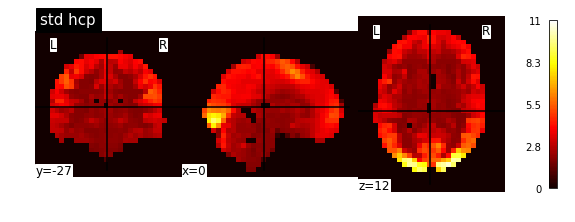

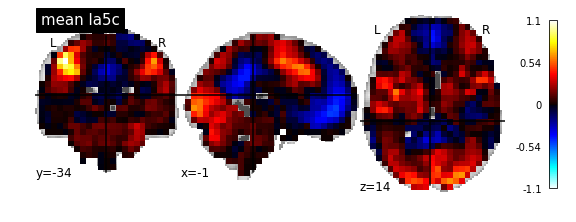

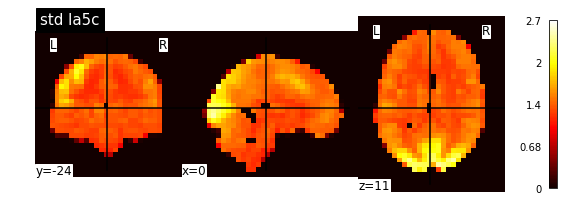

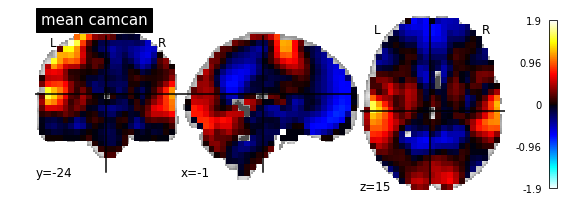

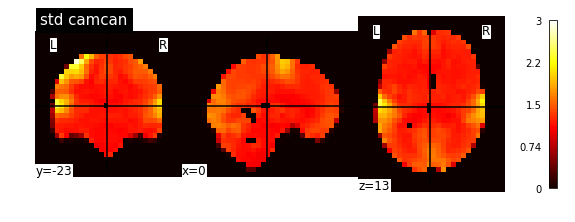

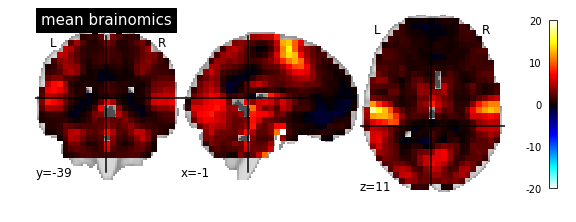

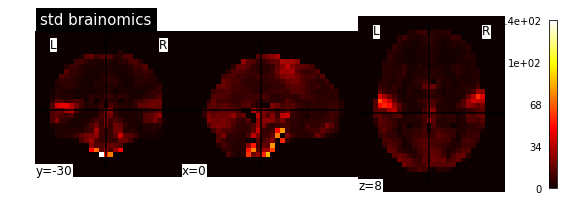

In [189]:
means = []
stds = []
for pos in range(stats_df.shape[0]):
    print(pos)
    mean_img = nibabel.Nifti1Image(
        (stats_df.iloc[pos].mean_image), downsampled_affine
    )
    means.append(mean_img)
    std_img = nibabel.Nifti1Image(
        (stats_df.iloc[pos].std_image), downsampled_affine
    )
    stds.append(std_img)
    plotting.plot_stat_map(
        math_img("img1", img1=mean_img),
        black_bg=False,
        title="mean {}".format(stats_df.iloc[pos].study)
    )
    plotting.plot_stat_map(
        math_img("img1", img1=std_img),
        black_bg=False,
        title="std {}".format(stats_df.iloc[pos].study)
    )


(30, 36, 30)


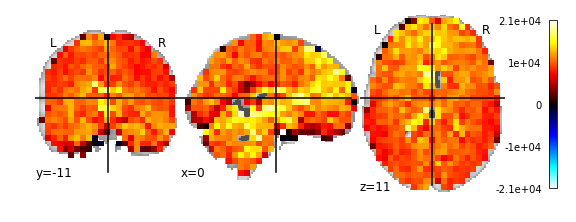

In [214]:
full_img = nibabel.load("/data/hcp/downsampled/rfMRI_REST_751348_1_LR_390.nii.gz")
plotting.plot_stat_map(
    full_img,
    black_bg=False,
)
print(full_img.get_data().shape)

In [235]:
from exploration import msssim
reload(msssim)

<module 'exploration.msssim' from '/data/brain_ae/conf/exploration/msssim.py'>

In [236]:
msssim_fn = msssim.MSSSIM(channel=1)

In [239]:
img1 = torch.from_numpy(nibabel.load("/data/hcp/downsampled/rfMRI_REST_751348_1_LR_390.nii.gz").get_data().astype(np.float32)).unsqueeze(0).unsqueeze(0).expand(10, 1, 30, 36, 30)
img2 = torch.from_numpy(nibabel.load("/data/hcp/downsampled/rfMRI_REST_751348_1_LR_390.nii.gz").get_data().astype(np.float32)).unsqueeze(0).unsqueeze(0).expand(10, 1, 30, 36, 30)
msssim_fn(img1, img2)

tensor(1.)

In [242]:
all_df = pd.read_csv("/data/neurovault/resampled_dataframe.csv")
all_studies = ['archi', 'hcp', 'la5c', 'camcan', 'brainomics']
trn, tst, train_loaders, test_loaders, mapping = hdataset.get_dataloaders(all_studies, 32, num_workers=0, debug=False)

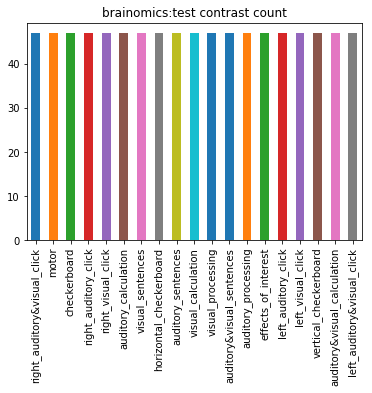

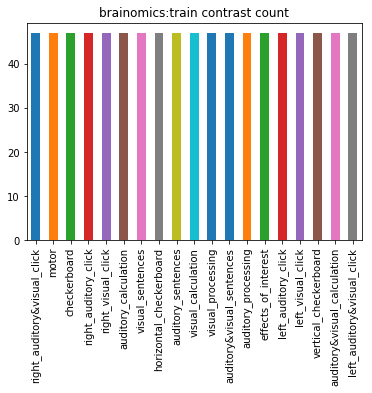

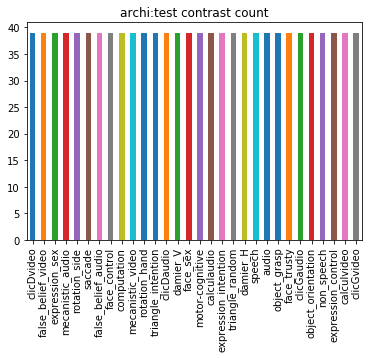

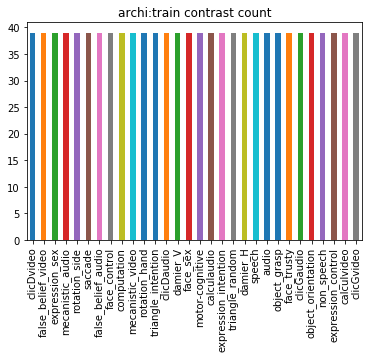

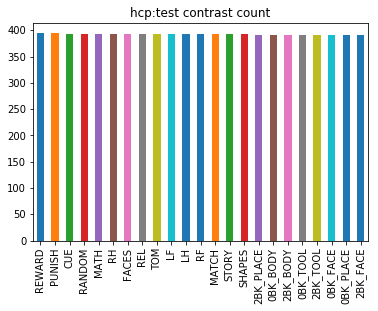

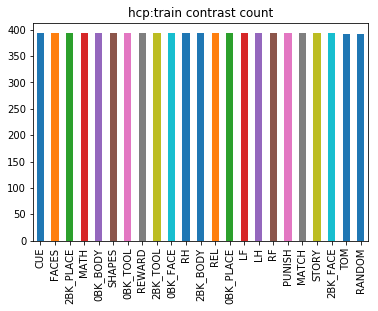

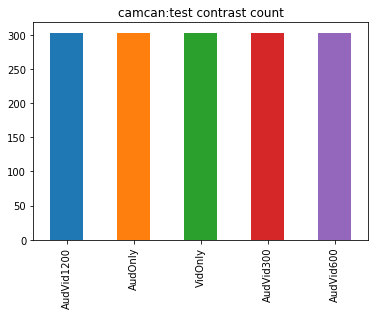

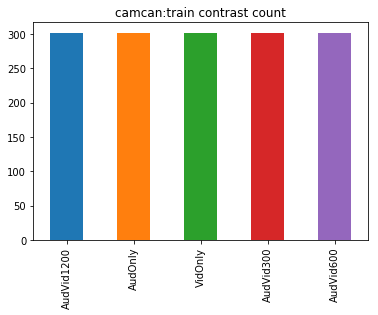

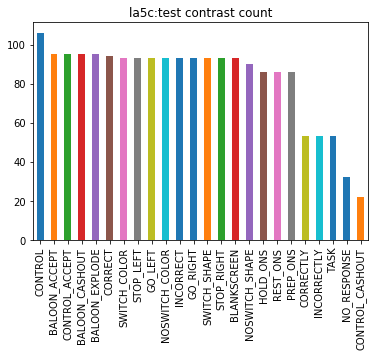

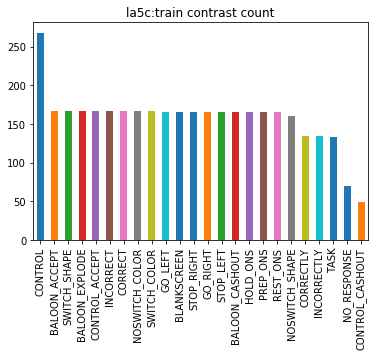

In [244]:
for k in trn.keys():
    for mode, ds in {"train": trn[k], "test": tst[k]}.items():
        fig, ax = plt.subplots()
        ds.df.contrast.value_counts().plot(ax=ax, kind='bar', title="{}:{} contrast count".format(k, mode))
        plt.show()

In [245]:
trn_c = {}
tst_c = {}
for k, v in trn.items():
    trn_c[k] = set(v.df.subject.unique().tolist())
for k, v in tst.items():
    tst_c[k] = set(v.df.subject.unique().tolist())
for k in trn_c.keys():
    print("intersection/trn/tst: {}/{}/{}".format(len(trn_c[k].intersection(tst_c[k])), len(trn_c[k]), len(tst_c[k])))

intersection/trn/tst: 0/47/47
intersection/trn/tst: 0/39/39
intersection/trn/tst: 0/95/96
intersection/trn/tst: 0/302/303
intersection/trn/tst: 0/393/394


In [250]:
full_mask.get_data().sum() / np.prod(full_mask.get_data().shape)

0.25309734121106237

In [255]:
full_mask.get_data()[:, -1, :].sum()

0

In [258]:
nibabel.load("/data/hcp/downsampled/rfMRI_REST_751348_1_LR_389.nii.gz").shape

(30, 36, 30)

In [267]:
img = nibabel.load("/data/hcp/ward_parcellation.nii.gz")
dat = img.get_data()
dat.shape

(53, 64, 52)

In [268]:
unq = np.unique(dat)
unq.shape

(30001,)

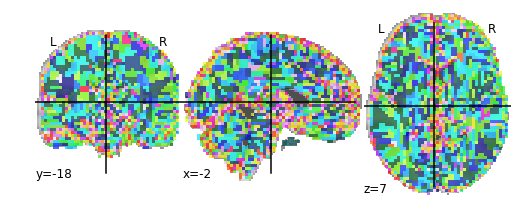

In [269]:
plotting.plot_roi(img)